<a href="https://colab.research.google.com/github/QuinnGrace/StatML4PopHealth/blob/changes/practicals/day5/practical7/phylo_lab2_mpxv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/imperial.png" width="250" vspace="8"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/mlgh.png" width="220" hspace="50" vspace="5"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/ammi.png" width="190"/>

<font size="6">Modern Statistics and Machine Learning <br>
for Population Health in Africa </font>

<font size="4">24th - 28th March 2025</font>

</center>

# Intro to Phylogenetics: Practical part 2
### AIMS-Imperial: Modern Statistics for Global Health
**Author**: Dr Alexandra Blenkinsop

**Objective**: This practical will demonstrate Bayesian phylogenetic inference using the package phylostan, to date a phylogenetic tree and estimate several parameters such as the evolutionary rate, tree height and effective population size.


❗Phylostan takes a long time so run so to make things easier we will provide the pregenerated phylostan output. However, if you would like to generate this output yourself, please uncomment the two code chunks below to install the packages required for phylostan.

If you decide to install phylostan, when installing setuptools you will be asked to restart your session - please click Restart session button. Note, this will erase the runtime state and local variable, so it is better to do this before running any other cells.

In [ ]:
## Uncomment this code chunk if you would like to run phylostan

# !pip install setuptools=="68.2.2"

In [ ]:
## Uncomment this code chunk if you would like to run phylostan

# !pystan=='2.19.1.1' nest-asyncio
# !pip install git+https://github.com/4ment/phylostan.git

In [ ]:
## Uncomment this code chunk if you would like to run phylostan

# import pystan

# # for phylostan
# import subprocess
# import shlex

# import nest_asyncio
# nest_asyncio.apply()

In [1]:
# install packages
!pip install biopython ete3 scikit-bio PyQt5 SciencePlots phytreeviz charset_normalizer arviz DendroPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 28.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 58.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.5/459.5 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 20.0 MB/s eta 0:00:00
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-

In [2]:
from pathlib import Path

from Bio import SeqIO, Phylo
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator
from Bio.Phylo.Consensus import *
from Bio.Phylo import write as phylo_write, draw
from ete3 import Tree, TextFace
from ete3 import Tree as EteTree
from ete3.treeview.main import TreeStyle, NodeStyle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
from skbio import DistanceMatrix
from skbio.tree import nj
import re
from phytreeviz import TreeViz
import os
import io
import arviz as az
from collections import defaultdict

from Bio.Phylo.Consensus import majority_consensus
import dendropy

# Aesthetics
sns.set_theme(style="whitegrid")
font = {"family": "sans-serif",
        "weight": "normal",
		"size": 10.5}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Adjust this as required - this is where your output will be stored.
output_dir = Path(*["drive", "MyDrive", "StatML4PopHealth", "practical7","mpxv"])
output_dir.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


### Data
The dataset for this practical lab contains 113 whole genome consensus sequences sampled in Nigeria between 2021-2023 from a study by Parker et al (2024, https://doi.org/10.1101/2024.06.18.24309104) estimating the timing of the emergence of the MPOX virus in humans. The alignment was obtained from NextStrain (https://nextstrain.org/mpox/all-clades), however for the purpose of this practical lab the alignment was subset to include only the sequences from the 2022-2023 oubreak in Nigeria. We will see the implications of this later.


### Read in the alignment

Your first task is to load the multiple sequence alignment and have a look at its structure.

In [5]:
# load the input data
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/day5/practical7/data/mpxv_alignment.fasta"

sequences = list(SeqIO.parse("mpxv_alignment.fasta", "fasta"))

# summarise alignment
print(f"Number of sequences: {len(sequences)}")

shortest_seq = min(sequences, key=lambda seq: len(seq.seq))
longest_seq = max(sequences, key=lambda seq: len(seq.seq))

print(f"- Shortest sequence: {shortest_seq.id} | Length: {len(shortest_seq.seq)}")
print(f"- Longest sequence: {longest_seq.id} | Length: {len(longest_seq.seq)}")

# print first sequence entry
record = sequences[0]
print(record)
print("ID:", record.id)
print("Description:", record.description)
print("Sequence type:", type(record.seq))
print("Sequence data:", record.seq)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21.2M  100 21.2M    0     0  6500k      0  0:00:03  0:00:03 --:--:-- 6499k
Number of sequences: 113
- Shortest sequence: PP852955_Nigeria_2022.496 | Length: 197209
- Longest sequence: PP852955_Nigeria_2022.496 | Length: 197209
ID: PP852955_Nigeria_2022.496
Name: PP852955_Nigeria_2022.496
Description: PP852955_Nigeria_2022.496
Number of features: 0
Seq('attttactattttatttagtgtctagaaaaaaatgtgtgacccacgaccgtagg...aat')
ID: PP852955_Nigeria_2022.496
Description: PP852955_Nigeria_2022.496
Sequence type: <class 'Bio.Seq.Seq'>
Sequence data: attttactattttatttagtgtctagaaaaaaatgtgtgacccacgaccgtaggaaactctagagggtaagaaaaatcaatcgtttatagagaccatcagaaagaggtttaatatttttgtgagacctatcgaagagagaaaggataaaaactttttacgactccatcagaaagaggtttaatatttttgtgagacccatcgaagagagaaagagatggttagtcaagatatttttcttagtacaaaagtcaatgttttaaaatatatggacgagaattaatttgtctgtataaaaact

### Visualizing Sequence Data
Let's visualize the alignment, recoding ambiguous bases as 'others'. The x-axis is the position in the alignment, but this is not meaningful unless it is mapped to some known genomic coordinates. The y-axis are the taxa. We show the first 30 taxa only.

What do you notice, comparing with the alignment of HIV sequences from the previous lab?

A:
- The length of the alignment is much longer (almost 200,000 nucleotides)
- The sequences look almost identical for the first 1000 positions - there are far fewer mutations than in the HIV alignment. This could be because the mutation rate is slower for MPXV, or because the sampling period covers a shorter time period

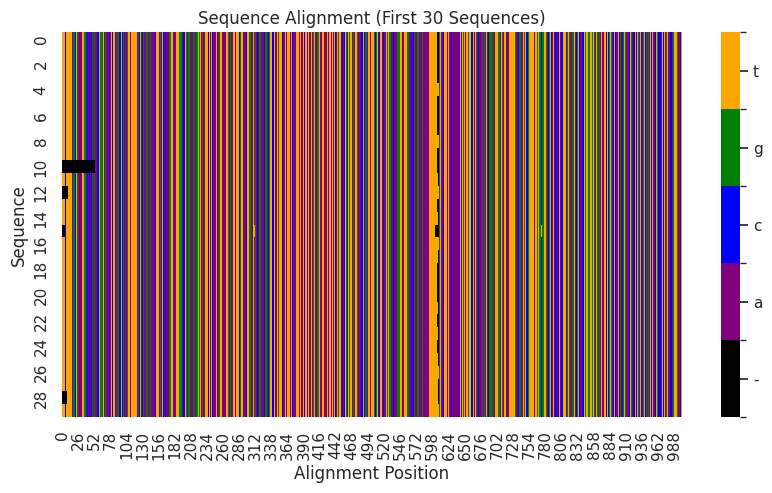

In [6]:
# define mapping for nucleotide bases
nucleotide_mapping = {'a': 1, 'c': 2, 'g': 3, 't': 4, '-': 0}
reverse_mapping = {v: k for k, v in nucleotide_mapping.items()}  # reverse ordering for legend
reverse_mapping[5] = 'Other'  # label for unknown bases

# convert sequences to a matrix of nucleotide characters
alignment_array = np.array([list(str(seq.seq)) for seq in sequences[:30]])

# convert nucleotides to numbers using the mapping
alignment_numeric = np.array([
    [nucleotide_mapping.get(nt, 5) for nt in str(seq.seq)]  # map unknown bases to 5
    for seq in sequences[:30]
])

# convert to DataFrame
alignment_df = pd.DataFrame(alignment_numeric)
alignment_df_subset = alignment_df.iloc[:, :1000]

# define a discrete colormap
colors = ["black", "purple", "blue", "green", "yellow","orange"]
cmap = mcolors.ListedColormap(colors[:len(nucleotide_mapping) + 1])
bounds = sorted(list(nucleotide_mapping.values()) + [max(nucleotide_mapping.values()) + 1])
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# plot as a heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(alignment_df_subset, cbar=True, cmap=cmap, norm=norm)

# formatting
colorbar = ax.collections[0].colorbar
tick_positions = np.array(bounds[:-1]) + 0.5
colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels([reverse_mapping.get(i, "Other") for i in bounds[:-1]])

# Labels and title
plt.title("Sequence Alignment (First 30 Sequences)")
plt.xlabel("Alignment Position")
plt.ylabel("Sequence")
plt.show()

# Pre-process alignment

The characters need to be all upper case and with no ambiguous characters to be used with most bioinformatic tools. Clean up the alignment and save it.

In [7]:
input_file = "mpxv_alignment.fasta"
output_file = os.path.join(output_dir, "cleaned_alignment.fasta")

# clean sequences while keeping gaps ("-")
with open(output_file, "w") as out_f:
    for record in SeqIO.parse(input_file, "fasta"):
        cleaned_seq = str(record.seq).upper()  # Convert to uppercase
        cleaned_seq = cleaned_seq.replace("?", "").replace(".", "")  # Remove unwanted characters

        # ensure each sequence contains at least one valid nucleotide (A, C, G, T, N)
        if any(c in "ACGTN" for c in cleaned_seq):
            record.seq = cleaned_seq  # update the sequence
            SeqIO.write(record, out_f, "fasta")
        else:
            print(f"Warning: Removed empty or invalid sequence {record.id}")

print(f" Cleaned alignment saved as: {output_file}")

sequences = list(SeqIO.parse(output_file, "fasta"))

/usr/local/lib/python3.11/dist-packages/Bio/SeqRecord.py:354: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


 Cleaned alignment saved as: drive/MyDrive/StatML4PopHealth/practical7/mpxv/cleaned_alignment.fasta


### Generating a Genetic Distance Matrix

Generate the pairwise distance matrix, assuming the Tamura and Nei model for the evolutionary rate, which has two parameters allowing for different base frequencies and different transition and substitution rates. This function generates a matrix of pairwise distances between taxa. Visualise the resulting matrix.

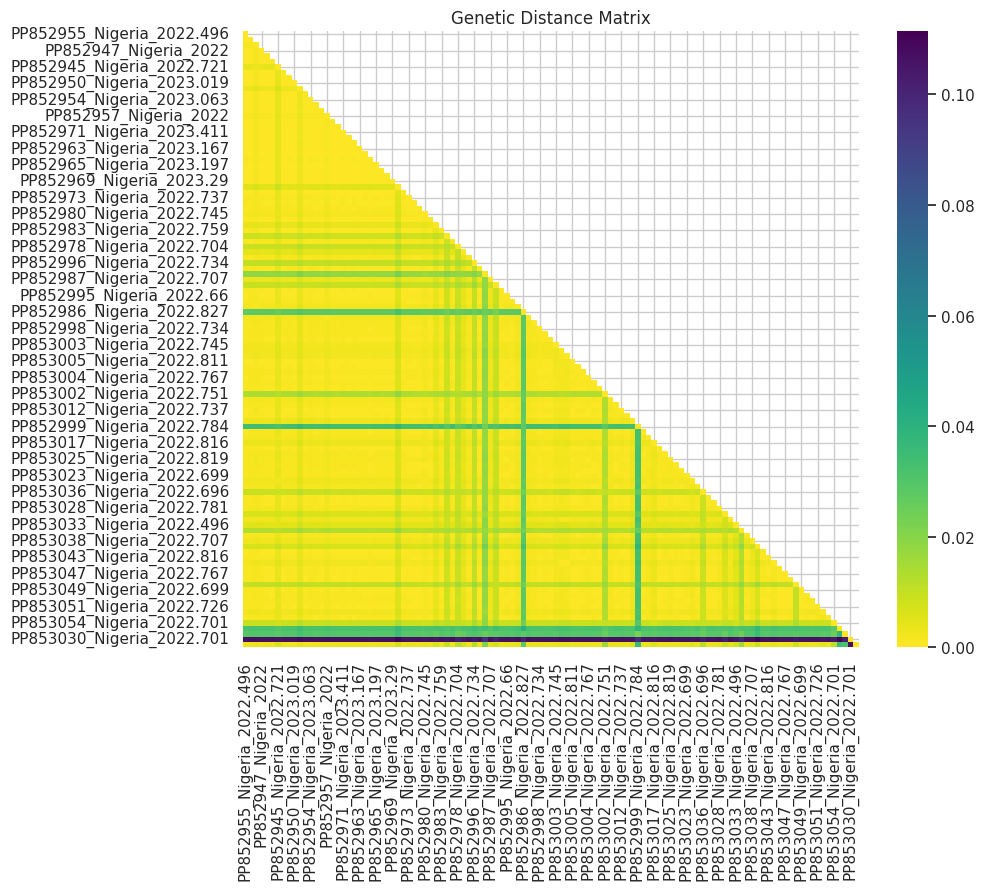

In [8]:
# calculate pairwise distance matrix
calculator = DistanceCalculator('identity')
alignment = MultipleSeqAlignment(sequences)
dmatrix = calculator.get_distance(alignment)

# convert to a DataFrame
dist_df = pd.DataFrame(dmatrix.matrix, index=dmatrix.names, columns=dmatrix.names)

# plot the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dist_df, cmap='viridis_r', square=True)
plt.title("Genetic Distance Matrix")
plt.show()

### Construct an initial tree using the neighbour-joining algorithm

We will first estimate the tree using the neighbour-joining approach and root the tree at the outgroup, accession number KJ642617, which was sampled in Nigeria in 1971.

Outgroup set to: KJ642617_Nigeria_REF_1971.282
Tree successfully re-rooted with 113 terminal nodes.


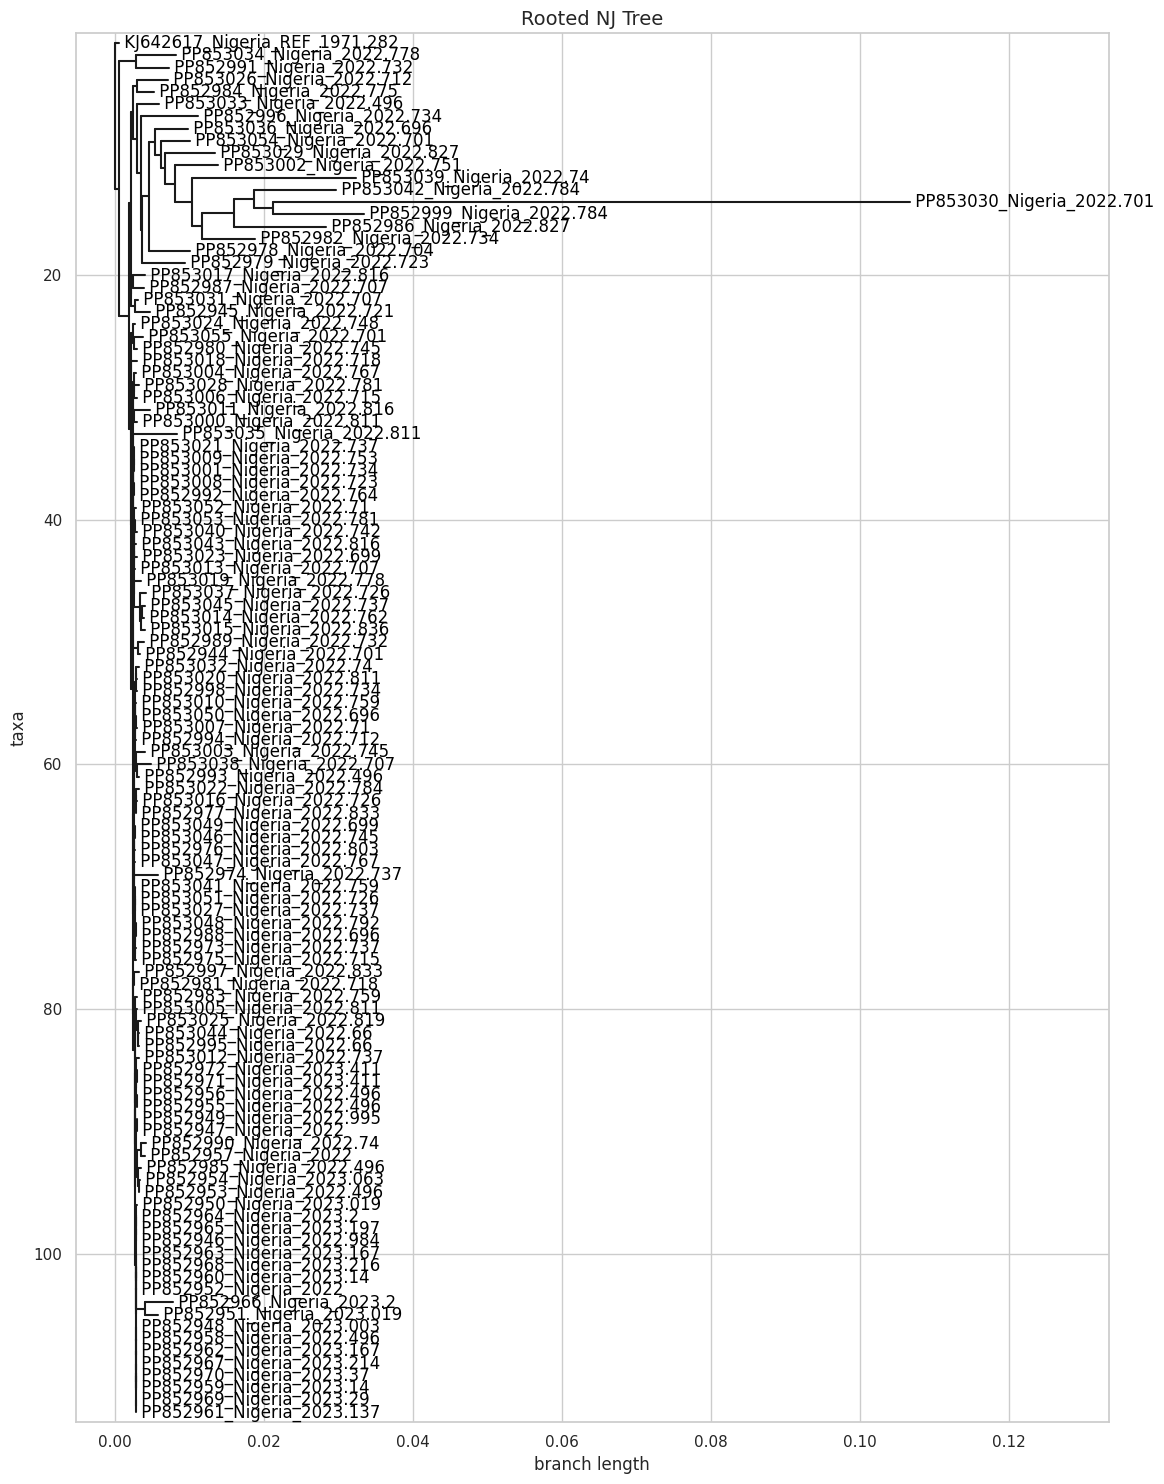

Tree saved successfully at: drive/MyDrive/StatML4PopHealth/practical7/mpxv/rooted_nj_tree_mpxv.png


In [9]:
# construct a NJ tree
constructor = DistanceTreeConstructor()
nj_tree = constructor.nj(dmatrix)

# convert to newick format for re-rooting
newick_tree = EteTree(nj_tree.format('newick'), format=1)

# identify the outgroup
outgroup_label = next((leaf.name for leaf in newick_tree.iter_leaves() if re.search(r'REF', leaf.name, re.IGNORECASE)), None)

# set the outgroup and root tree
if outgroup_label:
    newick_tree.set_outgroup(outgroup_label)
    print(f"Outgroup set to: {outgroup_label}")
else:
    print("No matching outgroup found!")

newick_string = newick_tree.write(format=1)
newick_io = io.StringIO(newick_string)

rooted_tree = Phylo.read(newick_io, "newick")
print(f"Tree successfully re-rooted with {len(rooted_tree.get_terminals())} terminal nodes.")

# draw the tree
fig, ax = plt.subplots(figsize=(12, 15))

Phylo.draw(
    rooted_tree,
    axes=ax,
    do_show=False,
    branch_labels=None,
    label_func=lambda clade: clade.name if clade.is_terminal() else None
)

# formatting
plt.title("Rooted NJ Tree", fontsize=14)
plt.tight_layout()

# save and plot
out_path = os.path.join(output_dir, 'rooted_nj_tree_mpxv.png')
plt.savefig(out_path, dpi=300, bbox_inches="tight")

# also save tree as newick format
tree_output_path = os.path.join(output_dir, 'rooted_nj_tree.tree')
Phylo.write(rooted_tree, tree_output_path, "newick")

plt.show()
print(f"Tree saved successfully at: {out_path}")

# Bayesian phylogenetic inference

Now let's look at inferring the tree with a Bayesian approach, using the phylostan package (github.com/4ment/phylostan).

The package uses pystan, but runs under the hood via the command line, so we just need to pass the relevant input files as arguments.

In [ ]:
## Uncomment this code chunk if you would like to run phylostan

# # file paths
# fasta = f"{output_dir}/cleaned_alignment.fasta"
# tree = f"{output_dir}/rooted_nj_tree.tree"  # Input tree
# # Get stan model
# !curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/refs/heads/main/practicals/day5/practical7/MPXV-GTR-W4.stan"
# !curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/refs/heads/main/practicals/day5/practical7/MPXV-GTR-W4.pkl"

# stan_model = "MPXV-GTR-W4.stan"
# output_prefix = f'{output_dir}/MPXV_output'  # Output file prefix
# output_tree_path = f'{output_dir}/MPXV_output.trees'

# command = [
#     "phylostan", "run",
#     "-s", stan_model,
#     "-m", "HKY",
#     "-C", "4",
#     "--heterochronous",
#     "--estimate_rate",
#     "--clock", "strict",
#     "--coalescent", "constant",
#     "-i", fasta,  # Input sequence alignment
#     "-t", tree,  # Input tree file
#     "-o", output_prefix,  # Output prefix
#     "-q", "meanfield"
#     #"-q", "mcmc"  # Change from "meanfield" (variational inference) to "mcmc"
# ]

# print(" Running Phylostan with the following command:")
# print(shlex.join(command))  # Formats the command as it would be executed in a shell

# print(" Running Phylostan...")
# try:
#     result = subprocess.run(command, check=True, capture_output=True, text=True)
#     print(" Phylostan Output:\n", result.stdout)
# except subprocess.CalledProcessError as e:
#     print(" Phylostan Error Output:\n", e.stderr)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5781  100  5781    0     0  13218      0 --:--:-- --:--:-- --:--:-- 13228
 Running Phylostan with the following command:
phylostan run -s MPXV-GTR-W4.stan -m HKY -C 4 --heterochronous --estimate_rate --clock strict --coalescent constant -i drive/MyDrive/StatML4PopHealth/practical7/mpxv/cleaned_alignment.fasta -t drive/MyDrive/StatML4PopHealth/practical7/mpxv/rooted_nj_tree.tree -o drive/MyDrive/StatML4PopHealth/practical7/mpxv/MPXV_output -q meanfield
 Running Phylostan...


KeyboardInterrupt: 

❗The code chunk below downloads the pregenerated phylostan output. If you would like to run phylostan yourself, please comment out the code chunk below and uncomment the code chunk above. Please remember to install phylostan before running it. Beware, it may take a few hours to run.

In [10]:
# Comment out this code chunk if you have run phylostan

!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/day5/practical7/MPXV_output"
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/day5/practical7/MPXV_output.trees"

output_prefix = "MPXV_output"
output_tree_path = "MPXV_output.trees"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4456k  100 4456k    0     0  1472k      0  0:00:03  0:00:03 --:--:-- 1472k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.7M  100 12.7M    0     0  4897k      0  0:00:02  0:00:02 --:--:-- 4899k


## Summarise posterior

We now summarise the posteriors of the estimated parameters.

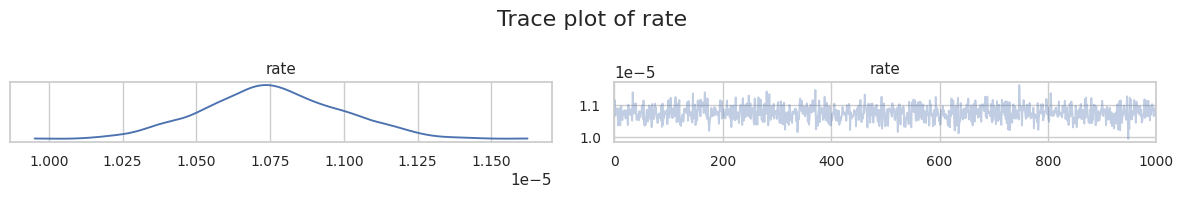

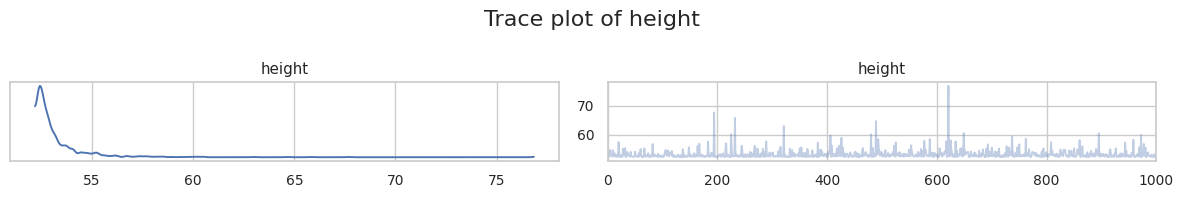

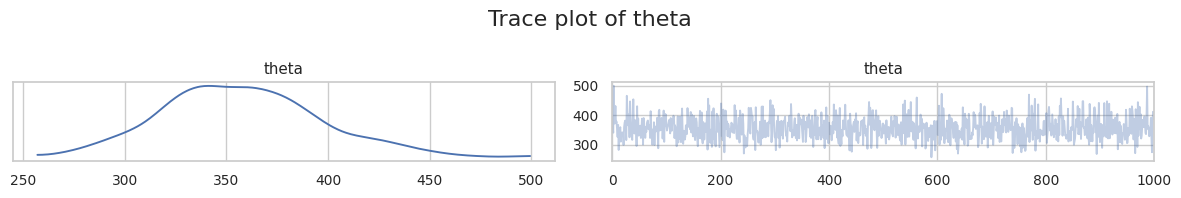

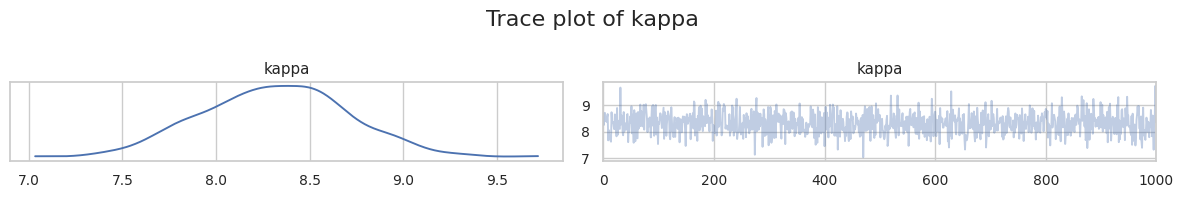

In [11]:
# tree height --> height
# evolutionary rate --> rate
# ratio of transition and transversion rates of HKY model --> kappa
# population size --> theta

po = az.from_cmdstan(posterior=output_prefix)

# parameter names
params_of_interest = ["rate", "height", "theta", "kappa"]

# trace plots for each parameter
for param in params_of_interest:
    az.plot_trace(po, var_names=[param])
    plt.suptitle(f"Trace plot of {param}", fontsize=16)
    plt.tight_layout()
    plt.show()

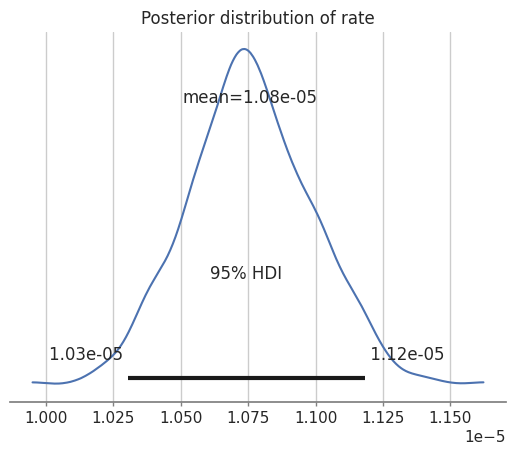

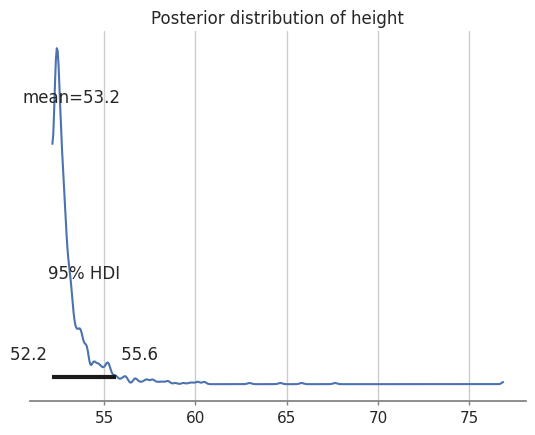

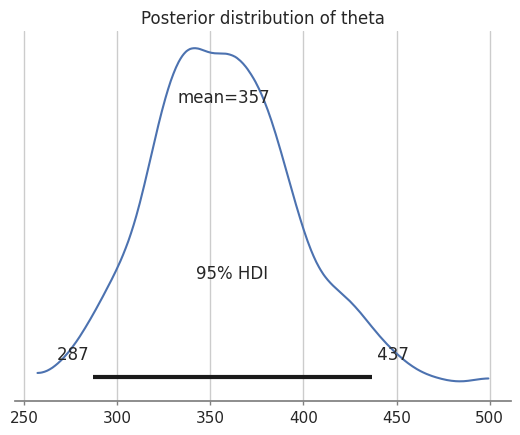

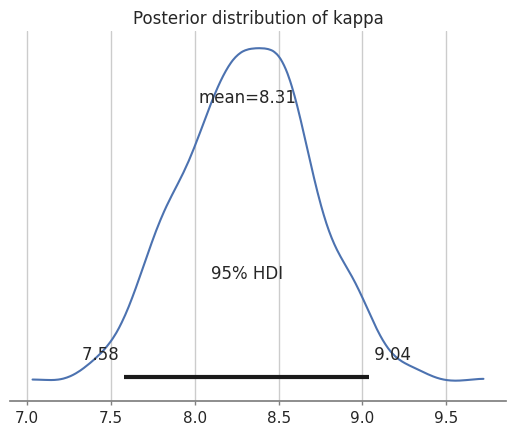

In [12]:
# We can also plot the posterior alone
# summarise posteriors|
for param in params_of_interest:
    az.plot_posterior(po, var_names=[param],hdi_prob=.95, round_to=3)
    plt.title(f"Posterior distribution of {param}")
    plt.show()

## Plot Maximum Clade Credibility tree

We would like to visualise the posterior samples of the tree. We can find the maximum clade credibility tree and plot it, showing the branch lengths in units of calendar time and illustrating the TMRCA of all the sampled taxa.

Comparing the TMRCA to that in Parker et al, we infer a much earlier emergence date of the outbreak. This illustrates the importance of including sufficient background sequences before attempting phylogenetic inference.

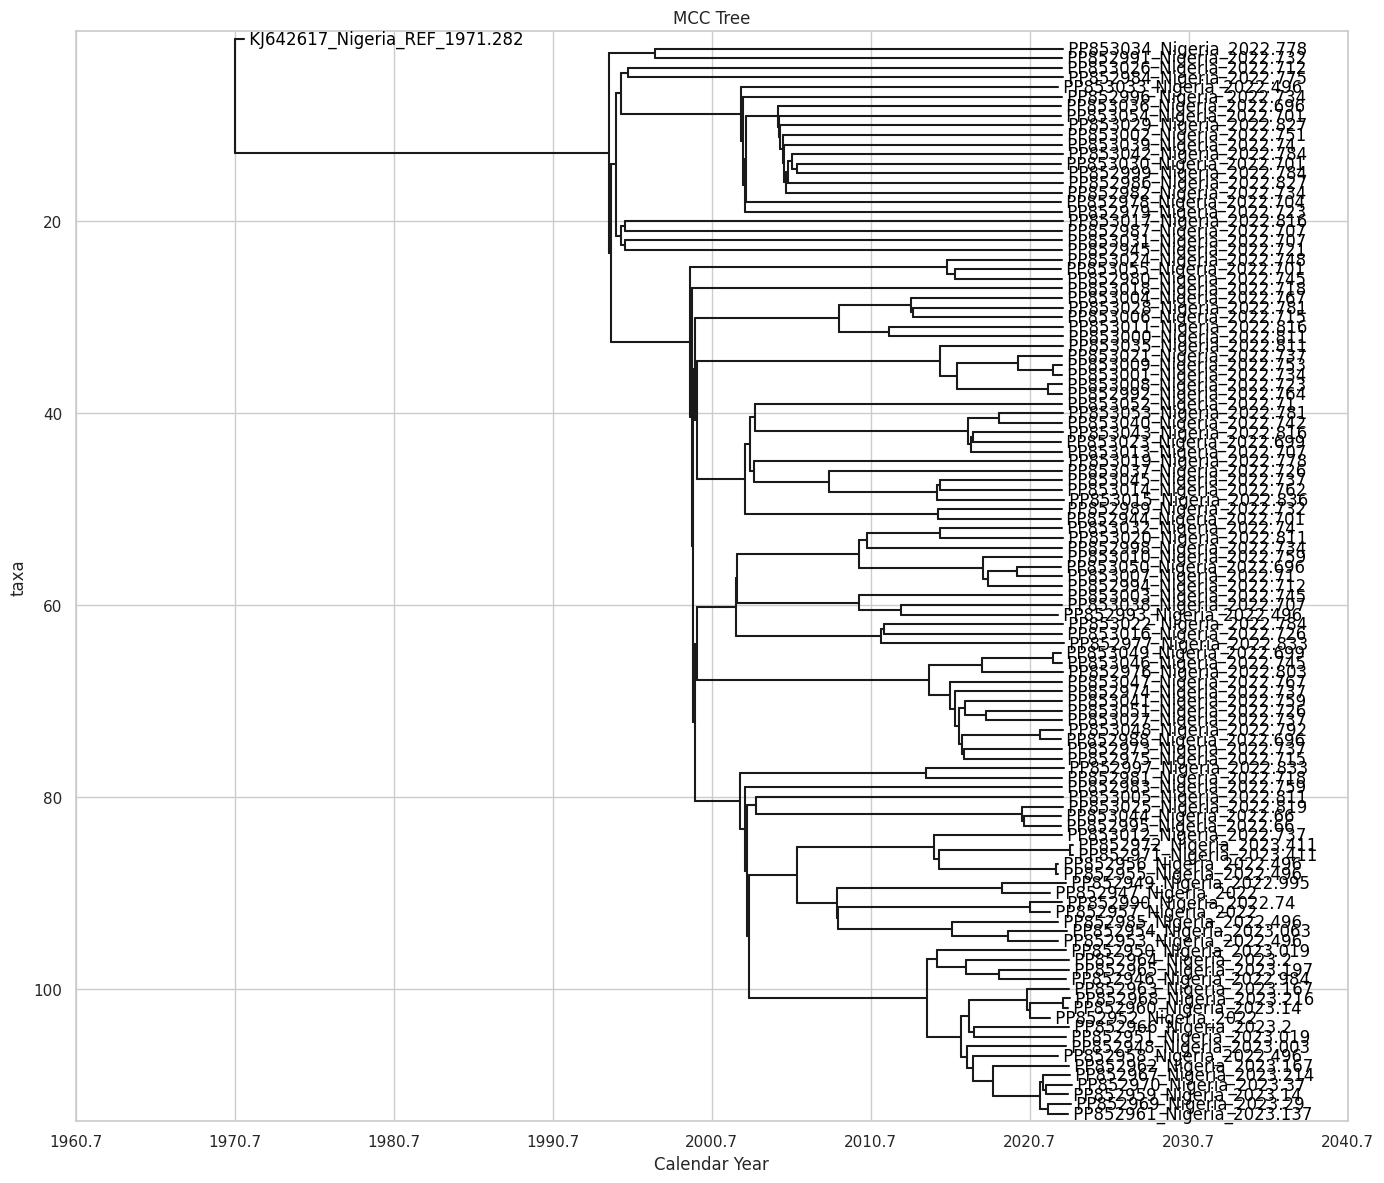

In [13]:
# load posterior trees
with open(output_tree_path) as f:
    lines = f.readlines()

# map taxa labels from posterior tree samples

translate_block = []
in_translate = False
for line in lines:
    if line.strip().lower().startswith("translate"):
        in_translate = True
        continue
    if in_translate:
        if ";" in line:
            break
        translate_block.append(line.strip())

translate_dict = {}
for line in translate_block:
    match = re.match(r"(\d+)\s+([^\s,]+)", line)
    if match:
        num, label = match.groups()
        translate_dict[num] = label

# read trees
tree_lines = [line for line in lines if line.strip().startswith("tree ")]
trees = []
for line in tree_lines:
    parts = line.split("=", 1)
    if len(parts) == 2:
        newick_str = parts[1].strip().rstrip(";")
        try:
            tree = Phylo.read(io.StringIO(newick_str), "newick")
            trees.append(tree)
        except:
            continue

# find MCC tree
def tree_topology_key(tree):
    clades = [frozenset(leaf.name for leaf in clade.get_terminals()) for clade in tree.find_clades()]
    return frozenset(clades)

topology_counts = defaultdict(int)
for tree in trees:
    key = tree_topology_key(tree)
    topology_counts[key] += 1

most_common_topology = max(topology_counts.items(), key=lambda x: x[1])[0]

mcc_tree = None
for tree in trees:
    if tree_topology_key(tree) == most_common_topology:
        mcc_tree = tree
        break

# relabel tips
for term in mcc_tree.get_terminals():
    if term.name in translate_dict:
        term.name = translate_dict[term.name]

# extract sampling dates
def extract_sampling_date(name):
    try:
        return float(name.split("_")[-1])
    except:
        return None

tip_dates = {term.name: extract_sampling_date(term.name) for term in mcc_tree.get_terminals()}
valid_dates = [d for d in tip_dates.values() if d is not None]
most_recent_year = max(valid_dates)
tree_depth = max(mcc_tree.distance(term) for term in mcc_tree.get_terminals())

# plot MCC tree with time-scaled x-axis
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(mcc_tree, axes=ax, do_show=False)

xticks = ax.get_xticks()
year_ticks = [round(most_recent_year - (tree_depth - x), 2) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(year_ticks)
ax.set_xlabel("Calendar Year")
ax.set_title("MCC Tree")
plt.tight_layout()
plt.show()